In [2]:
# 02_feature_engineering.ipynb
# Author: Onur Balic
# Description: Advanced feature engineering & node-level energy analysis

# ==========================
# Import necessary libraries
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# ==========================
# Load dataset
# ==========================
df = pd.read_csv("../data/butter_e_energy.csv")

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Show basic info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDate range:", df["timestamp"].min(), "to", df["timestamp"].max())
df.head()

Shape: (1059206, 3)

Columns: ['timestamp', 'node', 'watts']

Date range: 2022-09-22 16:28:01+00:00 to 2022-09-30 09:30:01+00:00


,timestamp,node,watts
0,2022-09-24 08:20:01+00:00,r103u05,721
1,2022-09-24 08:21:01+00:00,r103u05,470
2,2022-09-24 08:22:01+00:00,r103u05,461
3,2022-09-24 08:23:01+00:00,r103u05,458
4,2022-09-24 08:24:01+00:00,r103u05,462


In [3]:
# ==========================
# Node-based energy summary
# ==========================

# Calculate total, mean, std for each node
node_stats = (
    df.groupby("node")["watts"]
    .agg(["count", "sum", "mean", "std"])
    .sort_values(by="sum", ascending=False)
    .reset_index()
)

# Rename columns for clarity
node_stats.columns = ["node", "num_records", "total_watts", "avg_watts", "std_watts"]

# Display top 10 nodes
print("Top 10 nodes by total energy consumption:")
node_stats.head(10)

Top 10 nodes by total energy consumption:


,node,num_records,total_watts,avg_watts,std_watts
0,r103u05,8640,3961083,458.458681,19.563932
1,r103u07,8641,3952718,457.437565,22.779195
2,r103u01,8641,3852723,445.865409,21.087375
3,r105u13,8640,3559254,411.950694,21.821013
4,r103u19,5760,2665153,462.700174,22.682499
5,r103u09,5761,2633529,457.130533,23.799881
6,r103u11,5761,2631888,456.845687,19.922218
7,r105u07,5760,2544882,441.819792,22.838406
8,r104u37,5760,2544861,441.816146,23.282066
9,r103u15,5670,2543201,448.536332,32.980310


/var/folders/b1/85fh_qc57qgf67hvb9qdc9zr0000gn/T/ipykernel_7145/989041343.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_nodes, x="node", y="total_watts", palette="viridis")


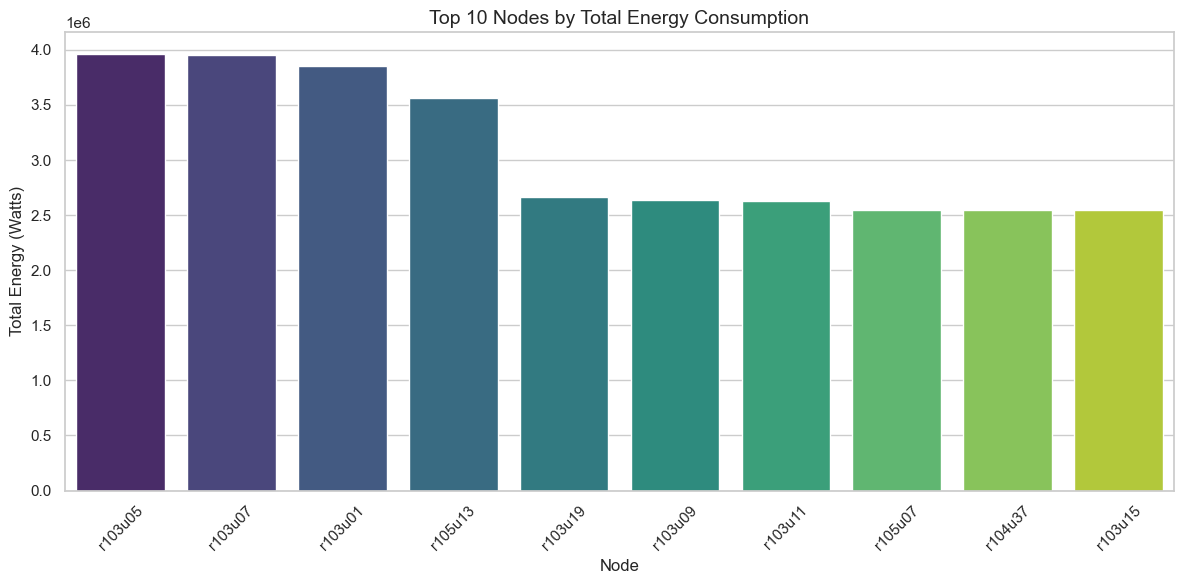

In [4]:
# ==========================
# Top 10 energy-consuming nodes
# ==========================
top10_nodes = node_stats.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top10_nodes, x="node", y="total_watts", palette="viridis")
plt.title("Top 10 Nodes by Total Energy Consumption", fontsize=14)
plt.xlabel("Node")
plt.ylabel("Total Energy (Watts)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 10 Nodes by Total Energy Consumption

- **r103u05, r103u07, r103u01** are the top 3 consumers, each close to 4M Watts.  
- The rest of the top 10 consume less (~2.5–3.5M Watts).  
- This shows an **imbalance in workload/energy distribution** across nodes.  
- Likely causes: heavier workloads, hardware differences, or scheduling inefficiencies.

/var/folders/b1/85fh_qc57qgf67hvb9qdc9zr0000gn/T/ipykernel_7145/54968859.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = df["timestamp"].dt.floor("H")


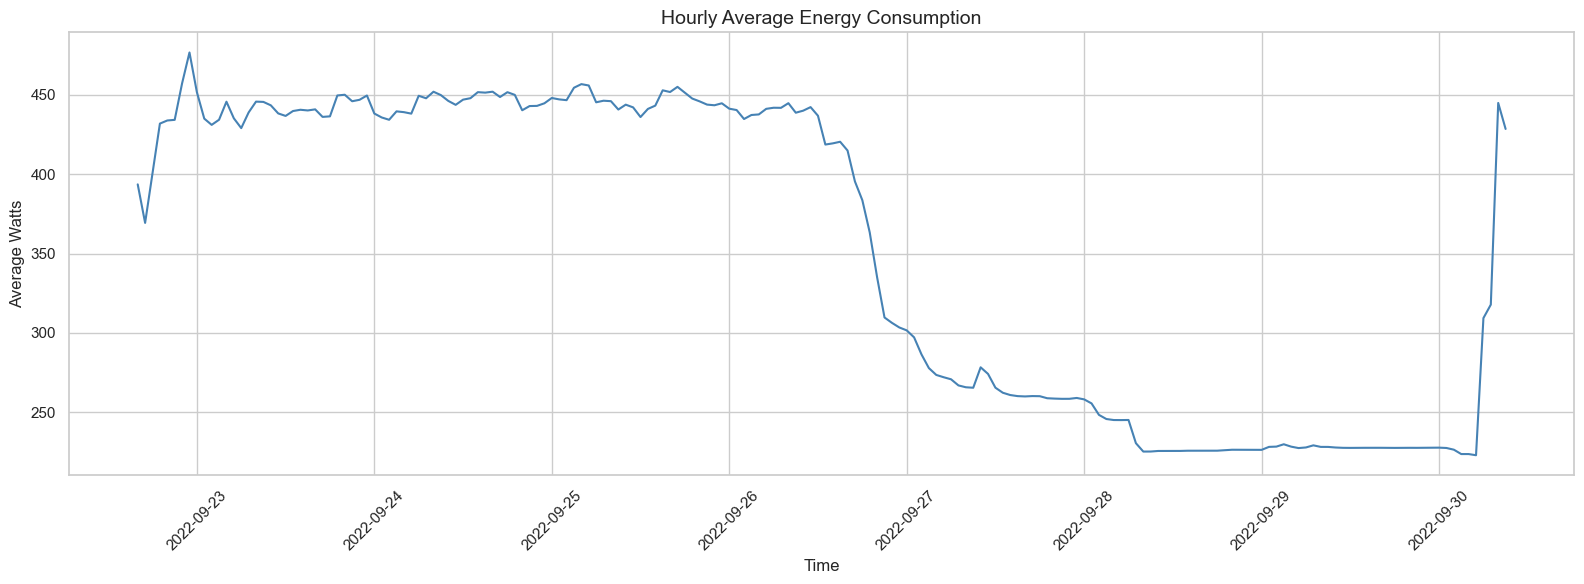

In [5]:
# ==========================
# Hourly average energy consumption
# ==========================

# Create a new column for hourly timestamps
df["hour"] = df["timestamp"].dt.floor("H")

# Group by hour and calculate average watts
hourly_avg = df.groupby("hour")["watts"].mean().reset_index()

# Plot the hourly trend
plt.figure(figsize=(16, 6))
plt.plot(hourly_avg["hour"], hourly_avg["watts"], color="steelblue")
plt.title("Hourly Average Energy Consumption", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Average Watts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Hourly Average Energy Consumption

- Energy usage was **stable and high (~440–460 W)** from Sept 23–26.  
- A clear **drop** started on Sept 26, reaching lows of ~220–250 W by Sept 28–29.  
- On Sept 30, consumption **spiked back up** toward ~440 W.  

**Interpretation:**  
This pattern suggests either a **scheduled downtime or reduced workload** in the middle of the week, followed by a **resumption of normal operations** at the end of the period.

/var/folders/b1/85fh_qc57qgf67hvb9qdc9zr0000gn/T/ipykernel_7145/184957823.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daily_avg, x="date", y="watts", palette="mako")


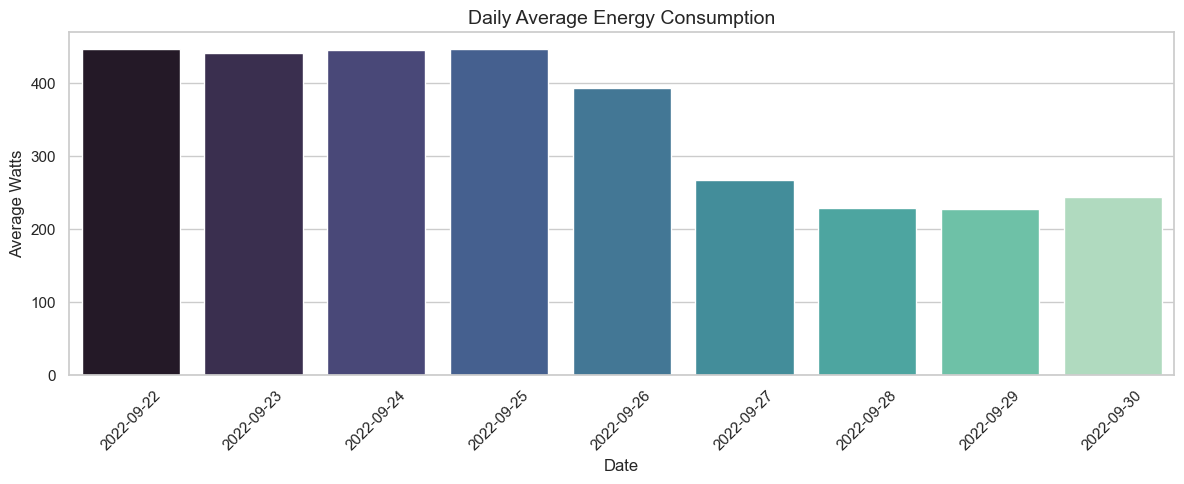

In [6]:
# ==========================
# Daily average energy consumption
# ==========================

# Create a new column for date
df["date"] = df["timestamp"].dt.date

# Group by date and calculate average watts
daily_avg = df.groupby("date")["watts"].mean().reset_index()

# Plot the daily trend
plt.figure(figsize=(12, 5))
sns.barplot(data=daily_avg, x="date", y="watts", palette="mako")
plt.title("Daily Average Energy Consumption", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Watts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

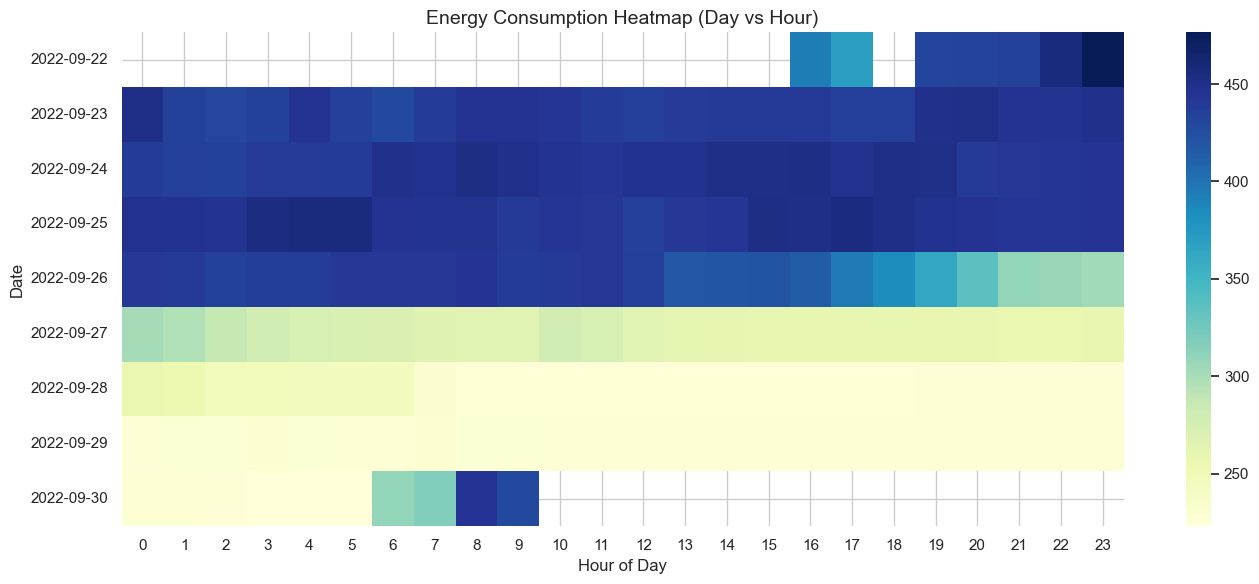

In [7]:
# ==========================
# Energy heatmap by day and hour
# ==========================

# Extract day and hour separately
df["day"] = df["timestamp"].dt.date
df["hour_of_day"] = df["timestamp"].dt.hour

# Calculate average watts for each day-hour combination
heatmap_data = df.groupby(["day", "hour_of_day"])["watts"].mean().unstack()

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title("Energy Consumption Heatmap (Day vs Hour)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

In [8]:
# ==========================
# Outlier Detection with IQR
# ==========================

Q1 = df["watts"].quantile(0.25)   # First quartile (25%)
Q3 = df["watts"].quantile(0.75)   # Third quartile (75%)
IQR = Q3 - Q1                      # Interquartile Range

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Mark anomalies
df["is_outlier"] = (df["watts"] < lower_bound) | (df["watts"] > upper_bound)

# Show how many anomalies
print("Number of anomalies:", df["is_outlier"].sum())
print("Percentage of anomalies:", round(df["is_outlier"].mean()*100, 2), "%")

Lower Bound: 206.0
Upper Bound: 238.0
Number of anomalies: 217251
Percentage of anomalies: 20.51 %


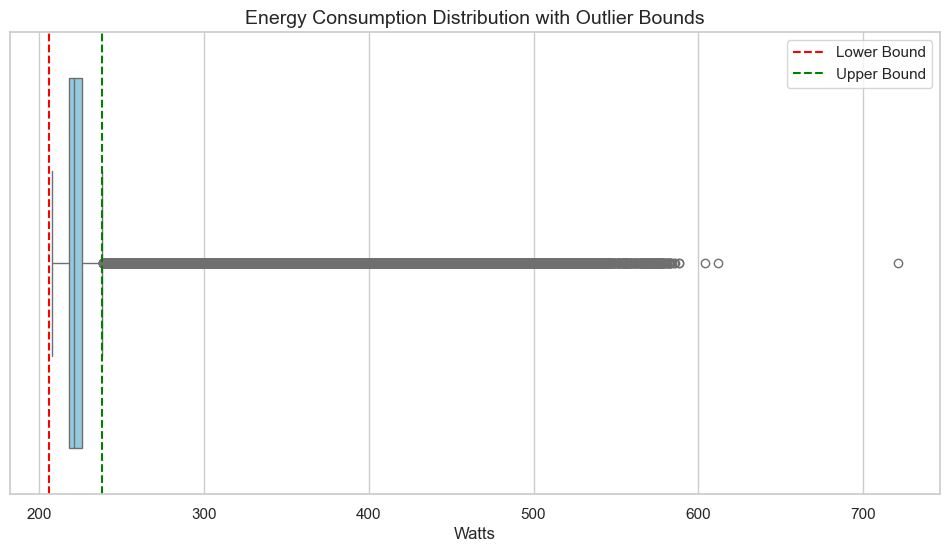

In [9]:
# ==========================
# Visualizing Outliers
# ==========================

plt.figure(figsize=(12, 6))
sns.boxplot(x=df["watts"], color="skyblue")
plt.axvline(lower_bound, color="red", linestyle="--", label="Lower Bound")
plt.axvline(upper_bound, color="green", linestyle="--", label="Upper Bound")
plt.title("Energy Consumption Distribution with Outlier Bounds", fontsize=14)
plt.xlabel("Watts")
plt.legend()
plt.show()

**Boxplot Interpretation:**
- The red dashed line indicates the lower bound (206 W), and the green dashed line indicates the upper bound (238 W).
- Most of the data points are actually outside this narrow range.
- This suggests that the IQR method is too strict for this dataset: values that are part of normal operations are being flagged as outliers.

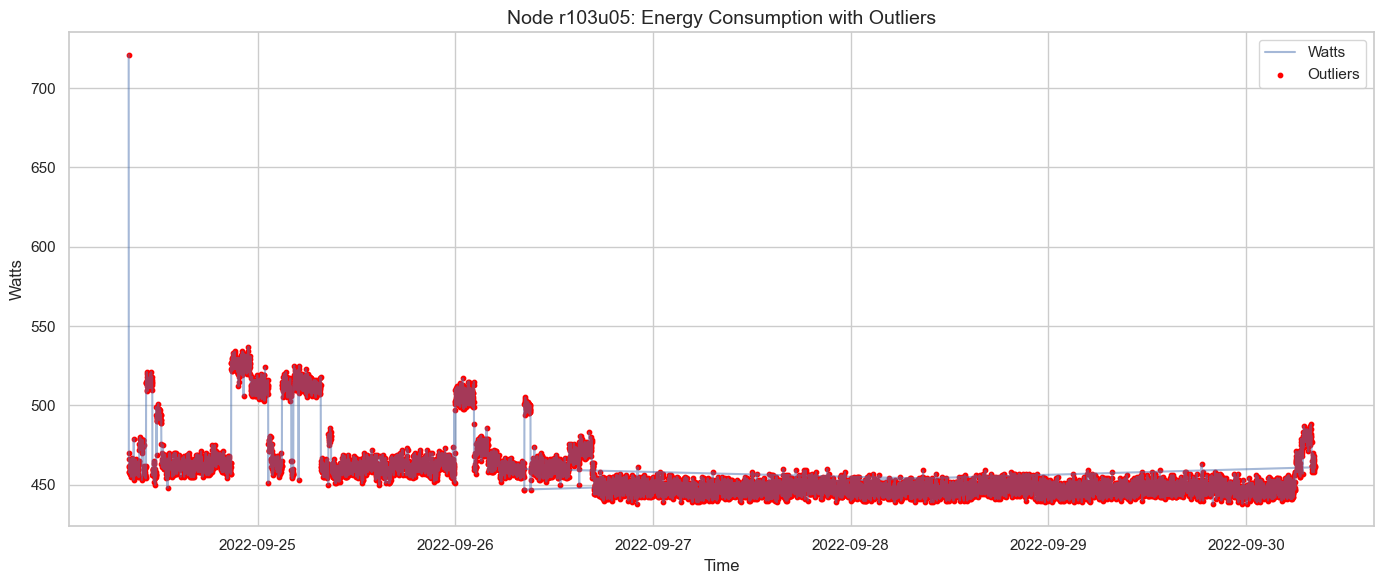

In [10]:
# ==========================
# Time Series with Outliers
# ==========================

sample_node = df[df["node"] == "r103u05"].copy()  # örnek bir node
plt.figure(figsize=(14, 6))
plt.plot(sample_node["timestamp"], sample_node["watts"], label="Watts", alpha=0.5)
plt.scatter(sample_node.loc[sample_node["is_outlier"], "timestamp"],
            sample_node.loc[sample_node["is_outlier"], "watts"],
            color="red", label="Outliers", s=10)
plt.title("Node r103u05: Energy Consumption with Outliers", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Watts")
plt.legend()
plt.tight_layout()
plt.show()

**Time Series Interpretation (Node r103u05):**
- The blue line shows the energy consumption trend of the node, while red dots mark the outliers.
- Almost the entire time series is covered with red dots, meaning IQR flagged a very high percentage (~20%) of the data as anomalies.
- While some true anomalies (e.g., spikes around 700 W) are visible, many normal values around 450 W are incorrectly labeled as outliers.

**Conclusion:**
- The IQR method provides a first look but tends to over-detect anomalies in this dataset.
- For a more realistic detection, alternative methods such as **Z-Score** or **Rolling Statistics** should be applied, as they can better adapt to the natural variability of energy consumption.

In [11]:
# ==========================
# Z-Score Based Anomaly Detection
# ==========================

from scipy.stats import zscore

# Calculate Z-Scores for the 'watts' column
df["zscore"] = zscore(df["watts"])

# Define threshold for anomalies
threshold = 3  # common choice: 2.5 or 3
df["is_outlier_z"] = (df["zscore"].abs() > threshold)

# Check anomaly stats
num_anomalies = df["is_outlier_z"].sum()
perc_anomalies = 100 * num_anomalies / len(df)

print(f"Number of anomalies: {num_anomalies}")
print(f"Percentage of anomalies: {perc_anomalies:.2f} %")

Number of anomalies: 4005
Percentage of anomalies: 0.38 %


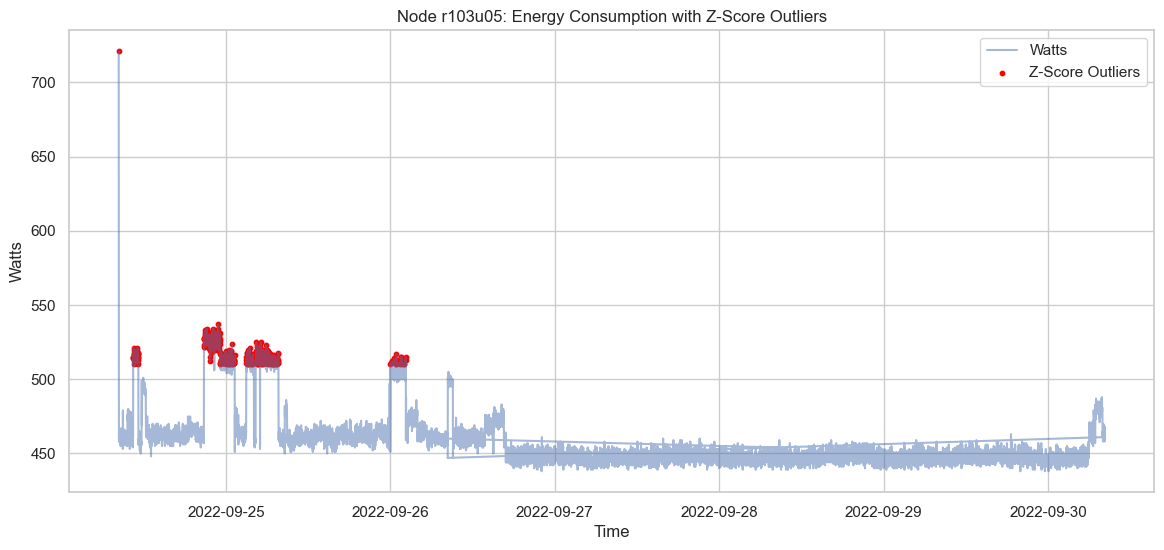

In [12]:
# Plot time series for one node with Z-Score anomalies
sample_node = df[df["node"] == "r103u05"]

plt.figure(figsize=(14,6))
plt.plot(sample_node["timestamp"], sample_node["watts"], label="Watts", alpha=0.5)
plt.scatter(sample_node.loc[sample_node["is_outlier_z"], "timestamp"],
            sample_node.loc[sample_node["is_outlier_z"], "watts"],
            color="red", label="Z-Score Outliers", s=10)
plt.title("Node r103u05: Energy Consumption with Z-Score Outliers")
plt.xlabel("Time")
plt.ylabel("Watts")
plt.legend()
plt.show()

### Z-Score Based Anomaly Detection

- Using a threshold of **|Z| > 3**, we detected **4005 anomalies**, which corresponds to only **0.38% of the data**.  
- Compared to the IQR method (~20% anomalies), this is much more reasonable and highlights **true extreme values**.  

**Observations from Node r103u05:**
- Red points indicate outliers such as sudden spikes above **700 W** or short bursts above **500 W**.  
- Normal fluctuations around **450 W** are no longer flagged, meaning Z-Score handles variability better than IQR.  

**Conclusion:**
- Z-Score filtering is effective for this dataset, as it avoids over-detecting anomalies.  
- These results can be used as a baseline for further **time-series anomaly detection** (e.g., rolling statistics, ML models).